# General tests of te AIS

Created on Tue Nov 22 16h24m,  2022

This is a script for the development of general tests

@author: denis


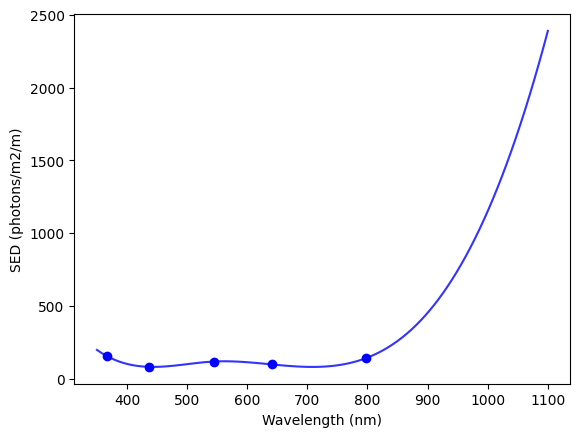

In [1]:
# Test sky SED
from AIS.Spectral_Energy_Distribution import Sky
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ss = pd.read_csv('AIS/Spectral_Energy_Distribution/moon_magnitude.csv')
wv = np.linspace(350, 1100, 100)
sky = Sky()
sky_sed = sky.calculate_sed('new', wv)
plt.plot(wv, sky_sed, 'b', alpha=0.8)
plt.plot(ss['wavelength'], sky._calculate_photons_density(ss['new']), 'ob')
plt.xlabel('Wavelength (nm)')
plt.ylabel('SED (photons/m2/m)')
plt.show()

In [ ]:
# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel, Atmosphere, Telescope
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)
_channel_id = 1
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, 'collimator.csv')
sr_total *= sr
plt.plot(wv, sr, label='collimator')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/dichroic.csv')
sr_total *= sr
plt.plot(wv, sr, label='dichroic')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/camera.csv')
sr_total *= sr
plt.plot(wv, sr, label='focalizer optics')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/ccd.csv')
sr_total *= sr
plt.plot(wv, sr, label='ccd camera')

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
sr_total *= sr
plt.plot(wv, sr, label='atmosphere')

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label='telescope')


plt.plot(wv, sr_total, 'k', label='total')
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.title(f'Channel {_channel_id}')
plt.savefig(os.path.join('notebook_figures', f'Channel {_channel_id}.png'))
plt.show()


In [ ]:
# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel, Atmosphere
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)
_channel_id = 2
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, 'collimator.csv')
sr_total *= sr
plt.plot(wv, sr, label='collimator')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/dichroic.csv')
sr_total *= sr
plt.plot(wv, sr, label='dichroic')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/camera.csv')
sr_total *= sr
plt.plot(wv, sr, label='focalizer optics')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/ccd.csv')
sr_total *= sr
plt.plot(wv, sr, label='ccd camera')

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
sr_total *= sr
plt.plot(wv, sr, label='atmosphere')

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label='telescope')

plt.plot(wv, sr_total, 'k', label='total')
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.title(f'Channel {_channel_id}')
plt.savefig(os.path.join('notebook_figures', f'Channel {_channel_id}.png'))
plt.show()


In [ ]:
# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel, Atmosphere, Telescope
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)
_channel_id = 3
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, 'collimator.csv')
sr_total *= sr
plt.plot(wv, sr, label='collimator')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/dichroic.csv')
sr_total *= sr
plt.plot(wv, sr, label='dichroic')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/camera.csv')
sr_total *= sr
plt.plot(wv, sr, label='focalizer optics')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/ccd.csv')
sr_total *= sr
plt.plot(wv, sr, label='ccd camera')

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
sr_total *= sr
plt.plot(wv, sr, label='atmosphere')

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label='telescope')

plt.plot(wv, sr_total, 'k', label='total')
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.title(f'Channel {_channel_id}')
plt.savefig(os.path.join('notebook_figures', f'Channel {_channel_id}.png'))
plt.show()


In [ ]:
# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel, Atmosphere
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)
_channel_id = 4
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, 'collimator.csv')
sr_total *= sr
plt.plot(wv, sr, label='collimator')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/dichroic.csv')
sr_total *= sr
plt.plot(wv, sr, label='dichroic')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/camera.csv')
sr_total *= sr
plt.plot(wv, sr, label='focalizer optics')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/ccd.csv')
sr_total *= sr
plt.plot(wv, sr, label='ccd camera')

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
sr_total *= sr
plt.plot(wv, sr, label='atmosphere')

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label='telescope')

plt.plot(wv, sr_total, 'k', label='total')
plt.legend()
#plt.ylim(0, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.title(f'Channel {_channel_id}')
plt.savefig(os.path.join('notebook_figures', f'Channel {_channel_id}.png'))
plt.show()


In [ ]:

# Test the sparc4 spectral response + atmosphere + telescope
from AIS.Spectral_Response import Channel, Atmosphere, Telescope
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sed = np.ones(100)
wv = np.linspace(400, 1100, 100)
atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
tel = Telescope()
sr *= tel.get_spectral_response(wv)
colors = ['r', 'g', 'b', 'k']
for i in [1, 2, 3, 4]:
    channel = Channel(i)
    channel.write_sparc4_operation_mode('photometry')
    ch1_spectral_response = channel.apply_spectral_response(sed, wv) #*sr
    plt.plot(wv, ch1_spectral_response, colors[i-1], label=f'Channel {i}')

data = pd.read_csv('notebook/data_files/g_filter.csv')
plt.plot(data['Wavelength (angstroms)']/10, data['Transmission'], 'r--', label='g filter')
data = pd.read_csv('notebook/data_files/r_filter.csv')
plt.plot(data['Wavelength (angstroms)']/10, data['Transmission'], 'g--', label='r filter')
data = pd.read_csv('notebook/data_files/i_filter.csv')
plt.plot(data['Wavelength (angstroms)']/10, data['Transmission'], 'b--', label='i filter')
data = pd.read_csv('notebook/data_files/z_filter.csv')
plt.plot(data['Wavelength (angstroms)']/10, data['Transmission'], 'k--', label='z filter')


plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance')
plt.savefig(os.path.join('notebook', 'figures', 'sparc4_photometry.png'))
plt.show()


In [ ]:
# Test the blackbody profile
from AIS. Artificial_Image_Simulator import Artificial_Image_Simulator
from AIS.Spectral_Energy_Distribution import Source
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed('blackbody', 15, (400, 1100, 100), 5700)
ais.create_sky_sed('new')
plt.plot(ais.wavelength, ais.source_sed, label='Blackbody')
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed, label='Blackbody with atmosphere')
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed,
         label='Blackbody with atmosphere and telescope')
ais.apply_sparc4_spectral_response('photometry')
plt.plot(ais.wavelength, ais.source_sed,
         label='Blackbody with atmosphere, telescope and SPARC4')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('SED (photons/m2/nm)')
plt.title('Blackbody SED')
plt.show()

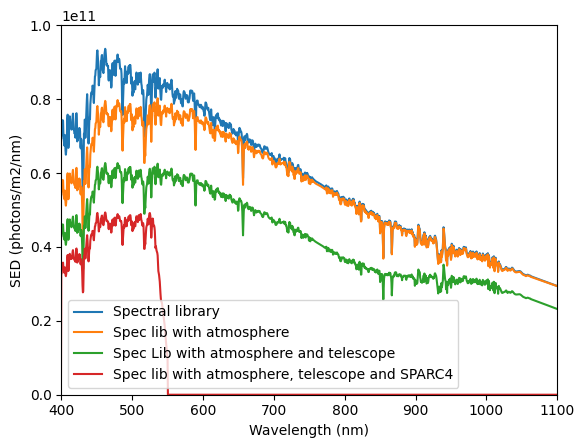

In [2]:
# Test the _read_spectral_library function
from AIS. Artificial_Image_Simulator import Artificial_Image_Simulator
from AIS.Spectral_Energy_Distribution import Source
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed('spectral_library', 15, (400, 1100, 100), spectral_type='g5v')
ais.create_sky_sed('new')
plt.plot(ais.wavelength, ais.source_sed, label='Spectral library')
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed, label='Spec lib with atmosphere')
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed,
         label='Spec Lib with atmosphere and telescope')
ais.apply_sparc4_spectral_response('photometry')
plt.plot(ais.wavelength, ais.source_sed,
         label='Spec lib with atmosphere, telescope and SPARC4')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('SED (photons/m2/nm)')
plt.xlim(400, 1100)
plt.ylim(0, 1e11)
plt.savefig('notebook/figures/spectral_library.png')
plt.show()

In [4]:
# Test the sbpy package
from sbpy.calib import Vega, vega_fluxd
print(vega_fluxd.get()["Johnson V"])


3.62701e-09 erg / (Angstrom cm2 s)


In [1]:
# Test the 

from AIS.Spectral_Energy_Distribution import Source

source = Source()
photons_per_sec = source._calculate_photons_density(15)
print(f'{photons_per_sec:.2e} photons/s')


8.23e+10 photons/s


In [ ]:

# Test the atmosphere spectral response
from AIS.Spectral_Response import Atmosphere
import matplotlib.pyplot as plt
import numpy as np

obj_wavelength = np.linspace(400, 1100, 100)
atmosphere = Atmosphere()
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1)
plt.plot(obj_wavelength, spectral_response)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.show()


In [ ]:
# Test telescope spectral response
from AIS.Spectral_Response import Telescope
import matplotlib.pyplot as plt
import numpy as np

obj_wavelength = np.linspace(400, 1100, 100)
telescope = Telescope()
spectral_response = telescope.get_spectral_response(obj_wavelength)
plt.plot(obj_wavelength, spectral_response, 'b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance')
plt.savefig('notebook_figures/telescope_spectral_response.png')
plt.show()


In [ ]:
# Test the PSF class
from AIS.Point_Spread_Function import Point_Spread_Function
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}
psf = Point_Spread_Function(ccd_operation_mode, 1)
image = psf.create_star_image((50, 50), 1e3, 1e3)
plt.imshow(image)
plt.show()

In [1]:
# Test the AIS.create_image function
from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator

ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

wavelength_interval = (400, 1100, 100)
ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)
ais.create_source_sed('blackbody', 15, wavelength_interval, 5700)
ais.create_sky_sed('new')
ais.apply_atmosphere_spectral_response(air_mass=1.2, sky_condition='photometric')
ais.apply_telescope_spectral_response()
ais.apply_sparc4_spectral_response('photometry')
ais.create_artificial_image(r'E:\images\test', (50, 50))

In [ ]:
# Calc the ajust of the spectral response of the telescope

import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, splev
from scipy.optimize import curve_fit
from sys import exit
import os

wv = [440, 530, 650]
M1 = [86.392, 85.641, 83.825]
M2 = [92.40375, 91.3025, 89.65375]

ss = pd.read_csv('AIS/Spectral_Response/telescope.csv')


def func(x, c):
    ss = pd.read_csv('AIS/Spectral_Response/telescope.csv')
    spl = splrep(ss['Wavelength (nm)'], ss['Transmitance (%)'])
    spectral_response = splev(x, spl)
    return spectral_response*c


popt_M1, _ = curve_fit(func, wv, M1)
popt_M2, _ = curve_fit(func, wv, M2)

plt.plot(wv, M1, 'o-r', label='M1')
plt.plot(wv, M2, 'o-b', label='M2')
plt.plot(ss['Wavelength (nm)'], ss['Transmitance (%)']
         * popt_M1[0], 'g', label=f'teórioco * {popt_M1[0]:.3f}')
plt.plot(ss['Wavelength (nm)'], ss['Transmitance (%)']
         * popt_M2[0], 'k', label=f'teórioco * {popt_M2[0]:.3f}')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflactance (%)')
plt.savefig(os.path.join('notebook_figures', 'adjust_aluminium_curve.png'))
plt.show()